In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf


df = pd.read_csv("IBM.csv", index_col='Date', parse_dates=["Date"])

In [2]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,78.824089,78.919693,77.256210,78.451241,44.594059,12253995
2006-01-04,78.585083,78.871895,77.753349,78.346077,44.534283,10285109
2006-01-05,77.820267,79.254303,77.676865,78.871895,44.833183,7545216
2006-01-06,80.258125,81.290634,79.741875,81.214149,46.164585,8573957
2006-01-09,80.210327,80.544930,79.713196,80.047798,45.501610,7166251


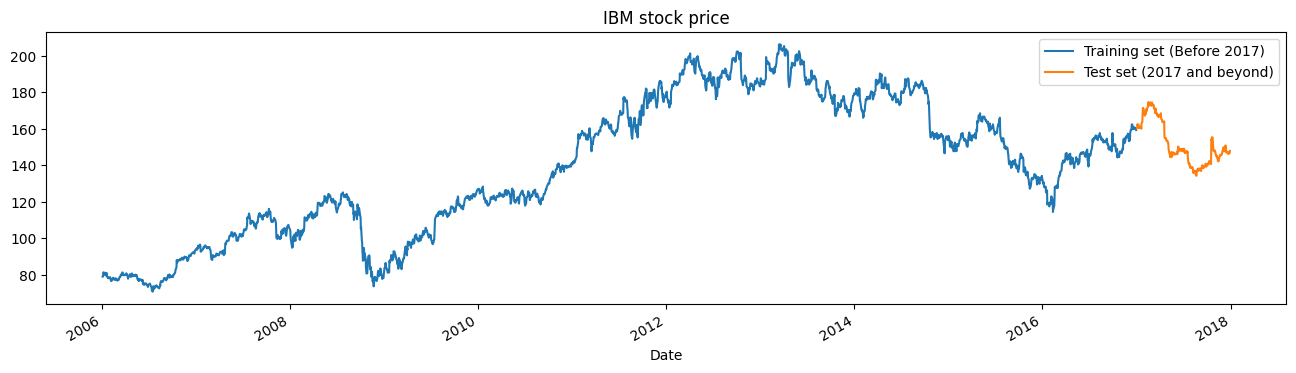

In [5]:
import matplotlib.pyplot as plt
# Plot the training set
df["High"][:'2016'].plot(figsize=(16, 4), legend=True)
# Plot the test set
df["High"]['2017':].plot(figsize=(16, 4), legend=True)
plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [6]:
training_set = df[:'2016'].iloc[:,1:2].values
test_set = df['2017':].iloc[:,1:2].values


sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# here we are seperating the data 
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i - 60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [8]:
class LSTM_Cell(tf.keras.layers.AbstractRNNCell):

    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)

        self.units = units

        self.forget_gate_layer = tf.keras.layers.Dense(units=units, activation="sigmoid")
        self.input_gate_layer = tf.keras.layers.Dense(units=units, activation="sigmoid")
        self.output_gate_layer = tf.keras.layers.Dense(units=units, activation="sigmoid")
       
        self.cell_state_candiate_layer = tf.keras.layers.Dense(units=units, activation="tanh")

    @property
    def state_size(self):
        return [tf.TensorShape(self.units), tf.TensorShape(self.units)]
    
    @property
    def output_size(self):
        return [tf.TensorShape(self.units), tf.TensorShape(self.units)]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        # hidden_state, cell_state
        return [tf.zeros(shape=(batch_size, self.units)), tf.zeros(shape=(batch_size, self.units))]
    

    def call(self, inputs, states):
        prev_hidden_state = states[0]
        prev_cell_state = states[1]

        concat_hidden_inputs = tf.concat([prev_hidden_state, inputs], axis=-1)

        #
        # Preparing
        #

        f = self.forget_gate_layer(concat_hidden_inputs)
        i = self.input_gate_layer(concat_hidden_inputs)

        cell_state_candiate = self.cell_state_candiate_layer(concat_hidden_inputs)

        #
        # Update cell state
        #

        cell_state = f * prev_cell_state +  i * cell_state_candiate

        #
        # Determinating hidden state and output
        #

        o = self.output_gate_layer(concat_hidden_inputs)

        hidden_state = o * tf.math.tanh(cell_state)

        return hidden_state, [hidden_state, cell_state]

In [9]:
class RNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.layer_list = [
            tf.keras.layers.RNN(LSTM_Cell(units=100), return_sequences=True),
            tf.keras.layers.Dropout(rate=0.3),
            tf.keras.layers.RNN(LSTM_Cell(units=80), return_sequences=True),
            tf.keras.layers.Dropout(rate=0.1),
            tf.keras.layers.RNN(LSTM_Cell(units=50), return_sequences=True),
            tf.keras.layers.Dropout(rate=0.2),
            tf.keras.layers.RNN(LSTM_Cell(units=30)),
            tf.keras.layers.Dropout(rate=0.3),
        ]
        
        self.output_layer = tf.keras.layers.Dense(units=1)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    @tf.function
    def call(self, sequence, training=False):
        x= sequence
        for layer in self.layer_list:
            x = layer(x)
        x = self.output_layer(x)
        return x

    
    @tf.function
    def train_step(self, data):
        """
        Standard train_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        with tf.GradientTape() as tape:
            output = self.call(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        Standard test_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        output = self.call(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80, return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))


regressor.compile(optimizer='adam',loss='mean_squared_error')

2024-04-02 08:59:54.577259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-02 08:59:54.577962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-02 08:59:54.578393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [11]:
model = RNNModel()

model.compile(optimizer='adam', loss='mean_squared_error')

# Modell trainieren
history = model.fit(X_train, y_train, epochs=50, batch_size=32) 

Epoch 1/50


2024-04-02 08:59:56.308149: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-02 08:59:56.618108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,60,1]
	 [[{{node data}}]]
2024-04-02 08:59:57.016480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype float and shape [?,60,1]
	 [[{{node data}}]]


85/85 [==============================] - 5s 42ms/step - loss: 0.0345
Epoch 2/50
85/85 [==============================] - 4s 46ms/step - loss: 0.0011
Epoch 3/50
85/85 [==============================] - 4s 45ms/step - loss: 9.9035e-04
Epoch 4/50
85/85 [==============================] - 4s 45ms/step - loss: 9.6157e-04
Epoch 5/50
85/85 [==============================] - 4s 46ms/step - loss: 8.5211e-04
Epoch 6/50
85/85 [==============================] - 4s 46ms/step - loss: 8.5662e-04
Epoch 7/50
 9/85 [==>...........................] - ETA: 3s - loss: 8.2553e-04

KeyboardInterrupt: 

In [15]:
regressor.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


2024-04-02 08:02:29.772918: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-04-02 08:02:29.890889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-04-02 08:02:29.891232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-04-02 08:02:29.891676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

85/85 [==============================] - 5s 41ms/step - loss: 0.0236
Epoch 2/50
85/85 [==============================] - 4s 44ms/step - loss: 0.0097
Epoch 3/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0079
Epoch 4/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0068
Epoch 5/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0066
Epoch 6/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0063
Epoch 7/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0062
Epoch 8/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0056
Epoch 9/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0051
Epoch 10/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0048
Epoch 11/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0048
Epoch 12/50
85/85 [==============================] - 4s 45ms/step - loss: 0.0045
Epoch 13/50
85/85 [=============================

In [46]:
dataset_total = pd.concat((df["High"][:'2016'], df["High"]['2017':]), axis=0)
inputs = dataset_total[len(dataset_total) - len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
print(predicted_stock_price)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print(predicted_stock_price)

8/8 [==============================] - 0s 11ms/step
[[0.66068935]
 [0.67033654]
 [0.68574214]
 [0.6803557 ]
 [0.684588  ]
 [0.68207043]
 [0.66881764]
 [0.66764706]
 [0.6700891 ]
 [0.6745865 ]
 [0.67192054]
 [0.67528635]
 [0.66532636]
 [0.6920652 ]
 [0.6938588 ]
 [0.7328059 ]
 [0.75280917]
 [0.74644935]
 [0.7482427 ]
 [0.7290401 ]
 [0.7209891 ]
 [0.7239559 ]
 [0.71908134]
 [0.7322127 ]
 [0.7269395 ]
 [0.7498641 ]
 [0.7356297 ]
 [0.74076885]
 [0.7473441 ]
 [0.7556028 ]
 [0.7560862 ]
 [0.77089757]
 [0.77507275]
 [0.7641588 ]
 [0.7591973 ]
 [0.7646782 ]
 [0.7742904 ]
 [0.7644776 ]
 [0.7643333 ]
 [0.75838906]
 [0.77630913]
 [0.76712614]
 [0.7647255 ]
 [0.7612696 ]
 [0.7648403 ]
 [0.7614638 ]
 [0.7480072 ]
 [0.75240606]
 [0.7394826 ]
 [0.7322329 ]
 [0.7286098 ]
 [0.7524302 ]
 [0.73010373]
 [0.7290812 ]
 [0.72781825]
 [0.7192178 ]
 [0.7258563 ]
 [0.7233331 ]
 [0.7130533 ]
 [0.72114515]
 [0.7155622 ]
 [0.71782285]
 [0.7199225 ]
 [0.71911705]
 [0.71982884]
 [0.7308692 ]
 [0.7054213 ]
 [0.705026

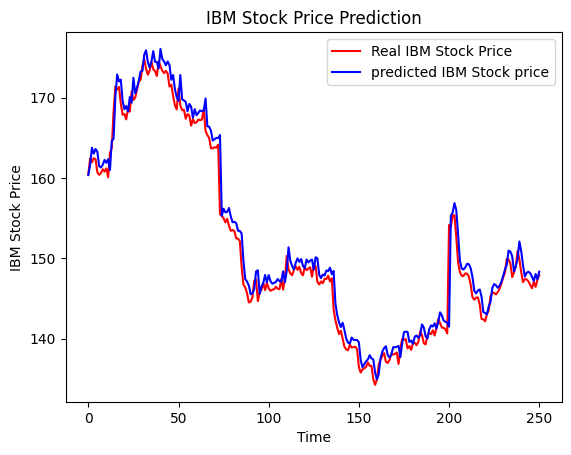

In [47]:
def plot_prediction(test,prediction):
    plt.plot(test,color='red',label="Real IBM Stock Price")
    plt.plot(prediction, color="blue",label="predicted IBM Stock price")
    plt.title("IBM Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("IBM Stock Price")
    plt.legend()
    plt.show()
# now we'll use this function to visualize our test and predicted data

plot_prediction(test_set,predicted_stock_price)